# Microstructural Research
## Features for MM

- Real-time 
- Historical
- Trades-based
- Orderbook-based
- Hybrid (both trades and orderbook)


### Real-time trade (with the same timestamp)
- raw: side, price, amount
- dollar amount  = price * amount
- signed amount = amount * (1 if side == 'buy' else -1)
- total price impact: last - first price of trades in the same timestamp
- average executed price
- slippage: average executed price - first price

### Historical Trades-based
- order arrival rate: # trades/ time
- pressure: sum(signed amounts)/time
  ```python
  trades['Pressure'] = trades['signed_amount'].rolling('1min').sum()
  ```
- volume: sum(amounts)
    ```python
    trades['Volume'] = trades['amount'].rolling('1min').sum()
    ```


### Real time orderbook-based
- mid price
- adjusted mid-price (best_bid_amount * best_bid + best_ask_amount * best_ask) / (best_bid_amount + best_ask_amount)
- bid-ask spread
- orderbook imbalance
- cumulative liquidity
```python
plt.plot(range(-100, 0), np.cumsum(LOB.bids[LOB.best_bid-99:LOB.best_bid+1])[::-1], color='green')
plt.plot(np.cumsum(LOB.asks[LOB.best_ask:LOB.best_ask+100]), color='red')
```
- largest orders in L levels
```python
largest_top_orders = [(LOB.best_bid-4+np.argmax(LOB.bids[LOB.best_bid-4:LOB.best_bid+1]))*0.1, (LOB.best_ask+np.argmax(LOB.asks[LOB.best_ask:LOB.best_ask+5]))*0.1]
```
- largest orders spread: largest ask-largest bid
```python
largest_top_orders_spread = largest_top_orders[1]-largest_top_orders[0]
```

### Historical orderbook-based
- order update rate: # limit order updates/ time
- order arrival rate: # new limit orders/ time
    - ignore orders outside our price range

### Historical Hybrid
-  order cancellation rate: # cancelled limit orders /time
-  order fill rate: # filled orders / time
-  

## Microstructural volatility (Historical)
- std of executed trades prices: std(avg executed trades)
- volume
- std of price impact
- biggest absolute price impact
- std of midprice change
- std of spread (and its variants) change
- price range: biggest midprice - smallest midprice

### volatility regimes
- quantiles of microstructural volatility (low/medium/high)
  - make quotes based on different regimes
  - interpolation between regimes (linear, polynomial, spline, sigmoid, )

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
import numpy as np

## Price Data

In [438]:
files = glob.glob("../data/prices/*")

In [562]:
prices = [json.loads(line[:-2]) for line in open(files[1], 'r')]

In [563]:
df = pd.DataFrame(prices)
df['ts'] = pd.to_datetime(df['ts'], unit = 'ms')
df = df.set_index('ts')

In [565]:
df['volatility'] = np.where(df['volatility']=="None", np.nan, df['volatility'])

In [566]:
for col in ["mid_price","spread","best_bid","best_ask","best_bid_size","best_ask_size","vamp","order_imbalance","volatility"]:
    #df[col] = pd.to_numeric(df[col])
    df[col] = df[col].apply(pd.to_numeric, args=('coerce',))

Text(0.5, 1.0, 'Volatility')

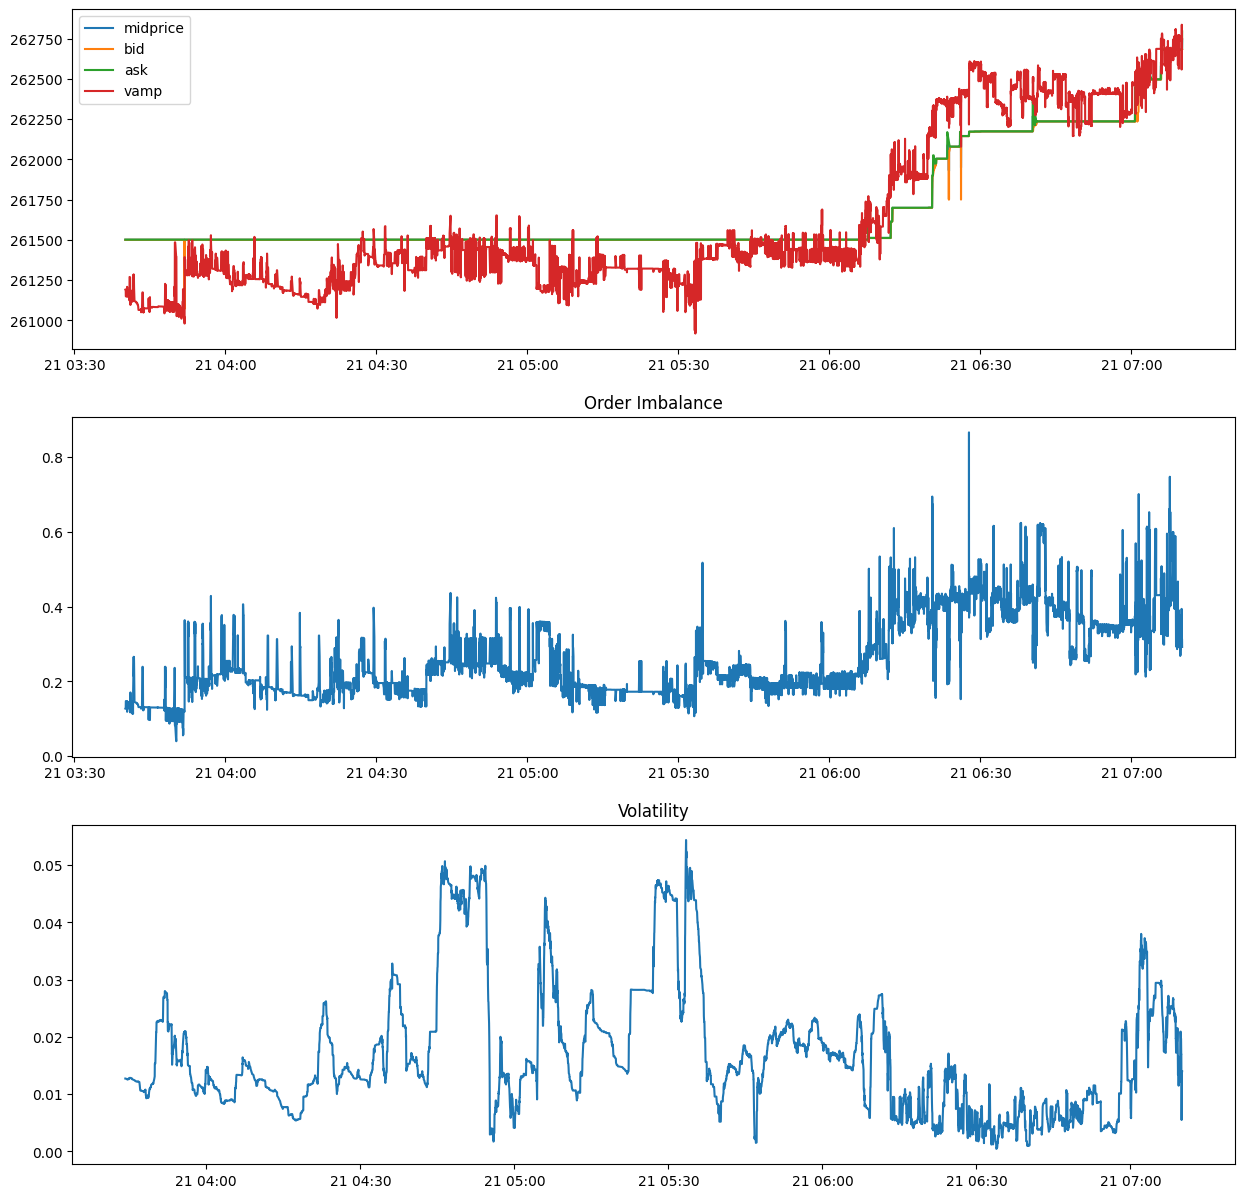

In [448]:
fig, (ax1,ax2, ax3) = plt.subplots(3,1, figsize = (15,15))
ax1.plot(df.mid_price,label="midprice")
ax1.plot(df.best_bid, label = "bid")
ax1.plot(df.best_ask, label ="ask")
ax1.plot(df.vamp, label = "vamp")
ax1.legend()
ax2.plot(df.order_imbalance)
ax2.set_title("Order Imbalance")
ax3.plot(df.volatility)
ax3.set_title("Volatility")

## Microstructure of Market Orders

In [449]:
glob.glob("../data/trades/*")

['../data/trades/trades_XBTMYR_0814.json',
 '../data/trades/trades_XBTMYR_0813.json',
 '../data/trades/trades_XBTMYR.json',
 '../data/trades/trades_UNIMYR.json',
 '../data/trades/trades_ETHMYR.json',
 '../data/trades/trades_MATICMYR_0815.json']

In [480]:
trades = pd.DataFrame([json.loads(line[:-2]) for line in open(glob.glob("../data/trades/*")[2], 'r')])

In [481]:
trades.amount.min(),trades.amount.max()

(5.3e-05, 0.240896)

In [483]:
trades['ts'] = pd.to_datetime(trades['ts'], unit = 'ms')
for col in ['price','amount']:
    trades[col] = pd.to_numeric(trades[col])

### Arrival time

### CDF

$PnL * P[\text{Filled in the next trade}]$

$PnL_{buy} = Distance_{buy} - fee$

$PnL_{sell} = Distance_{sell} - fee$

Reference: https://www.vertoxquant.com/p/an-improved-market-making-strategy?utm_source=publication-search 

In [453]:
buy_trades = trades.loc[trades['bidask']=="bid"]
sell_trades = trades.loc[trades['bidask']=="ask"]

In [457]:
buy_cdf = []
sell_cdf = []
range = np.arange(trades.amount.min(), trades.amount.max(),0.1)
for size in range:
    filtered_buy_trades = buy_trades[buy_trades['amount'] >= size]
    filtered_sell_trades = sell_trades[sell_trades['amount'] >= size]

    buy_cdf.append(len(filtered_buy_trades)/len(buy_trades))
    sell_cdf.append(len(filtered_sell_trades)/len(sell_trades))


In [458]:
CDF = pd.DataFrame({'Buy':buy_cdf, 'Sell':sell_cdf}, index=range)

Text(0, 0.5, 'probability')

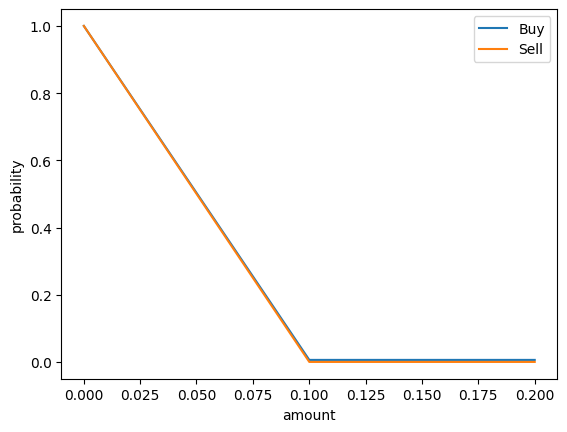

In [459]:
CDF.plot()
plt.xlabel('amount')
plt.ylabel('probability')

### Poisson process

Poisson intensity $\lambda(\delta)=Aexp(-k\delta)$

where $\delta$ = distance of the MM quote to the mid-price

We will fit the distance of the trade to midprice against amount.

Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [460]:
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning

In [461]:
sorted_trades = trades.groupby('distance').agg({'amount':'sum'}).reset_index().sort_values('distance')

In [463]:
params = curve_fit(lambda t, a,b: a*np.exp(-b*t), 
                   sorted_trades['distance'].to_list(), 
                   sorted_trades['amount'].to_list(),
                   p0 = (0,0),
                   method = "dogbox", 
                   bounds = ([0,0], [np.inf, np.inf]))

In [464]:
alpha, kappa = params[0]
alpha,kappa

(218.62293525120964, 8.98874314417166)

In [469]:
sorted_trades['distance'].max()

429.5

(0.0, 4.0)

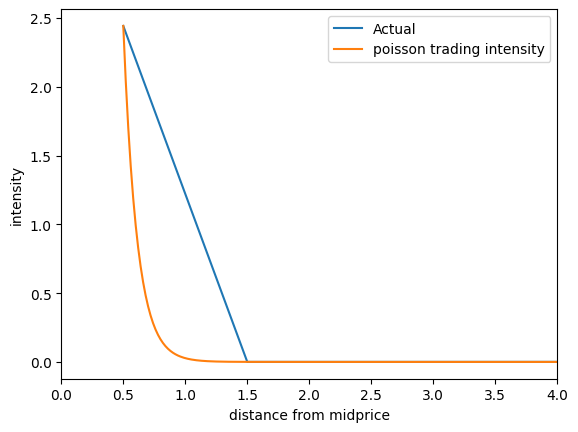

In [475]:
max_distance = 4
distance = np.arange(sorted_trades['distance'].min(), max_distance, 0.01)
plt.ylabel('intensity')
plt.xlabel('distance from midprice')
plt.plot(sorted_trades.distance, sorted_trades.amount, label = "Actual")
plt.plot(distance, alpha*np.exp(-distance*kappa), label = "poisson trading intensity")
plt.legend()
plt.xlim([0,max_distance])

## Trades

In [485]:
trades = trades.set_index('ts')

In [584]:
trades.head()

,price,amount,mid_price,distance,bidask,signed_amount,dollar_amount,pressure,volume
ts,,,,,,,,,
2024-08-21 03:40:08.477,261500.0,0.000338,261500.5,0.5,ask,-0.000338,88.3870,-0.000338,0.000338
2024-08-21 03:40:21.809,261500.0,0.000337,261500.5,0.5,ask,-0.000337,88.1255,-0.000675,0.000675
2024-08-21 03:40:22.557,261500.0,0.000337,261500.5,0.5,ask,-0.000337,88.1255,-0.001012,0.001012
2024-08-21 03:40:24.975,261500.0,0.000337,261500.5,0.5,ask,-0.000337,88.1255,-0.001349,0.001349
2024-08-21 03:40:28.432,261500.0,0.000202,261500.5,0.5,ask,-0.000202,52.8230,-0.001551,0.001551


In [ ]:
# autocorrelation of trades



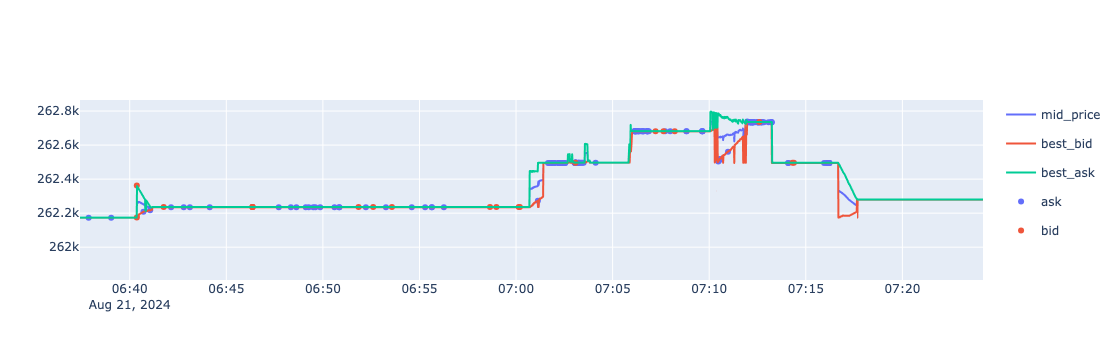

In [583]:
import plotly.express as px
import plotly.graph_objects as go

fig1 = px.line(df, x=df.index, y=["mid_price","best_bid","best_ask"])
fig2 = px.scatter(trades, x=trades.index, y="price", color = "bidask")
fig = go.Figure(data=fig1.data + fig2.data )
fig.show()

In [491]:
trades['signed_amount'] = np.where(trades['bidask']=="ask", -trades['amount'], trades['amount'])
trades['dollar_amount'] = trades['price'] * trades['amount']

In [492]:
trades['pressure'] = trades['signed_amount'].rolling('1min').sum()
trades['volume'] = trades['amount'].rolling('1min').sum()

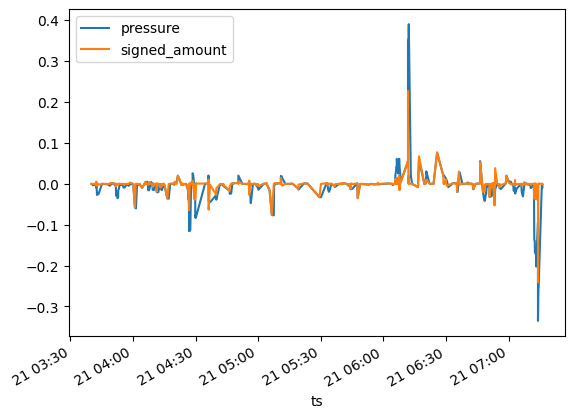

In [499]:
trades.pressure.plot(label = 'pressure')
trades.signed_amount.plot(label = 'signed_amount')
plt.legend()

<Axes: xlabel='ts'>

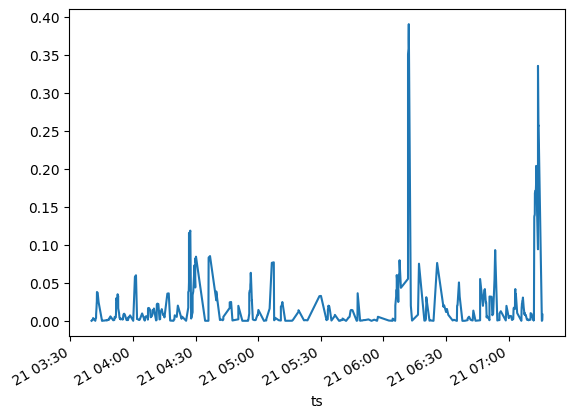

In [496]:
trades.volume.plot()

## Cancellation Rate

In [505]:
cancel = pd.DataFrame([json.loads(line[:-2]) for line in open(glob.glob("../data/cancel/*")[0], 'r')])

In [506]:
cancel['ts'] = pd.to_datetime(cancel['ts'], unit = 'ms')

<Axes: xlabel='ts'>

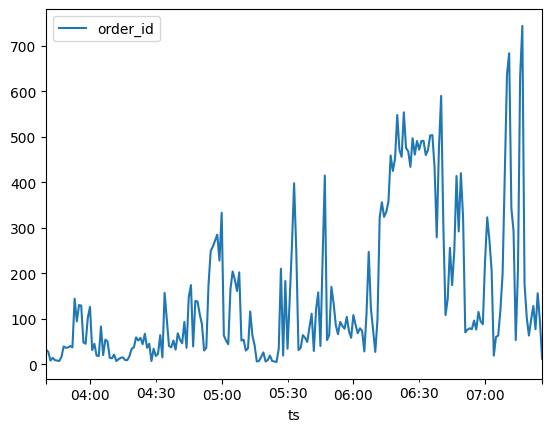

In [513]:
cancel.set_index('ts').resample('1min').count().plot()

## Arrival Rate

In [508]:
orders = pd.DataFrame([json.loads(line[:-2]) for line in open(glob.glob("../data/orders/*")[0], 'r')])

In [509]:
orders['ts'] = pd.to_datetime(orders['ts'], unit = 'ms')

In [510]:
orders

,ts,price,volume,order_id
0,2024-08-21 03:40:07.891,260146.0,0.041388,BXCNFEE8FV8SQS4
1,2024-08-21 03:40:07.964,260146.0,0.041256,BXNXNXYE3QV2HP7
2,2024-08-21 03:40:12.898,260874.0,0.034526,BXCAYX8GQBS6R4P
3,2024-08-21 03:40:13.010,260874.0,0.034395,BXBMR42DVAPQMXU
4,2024-08-21 03:40:13.089,260874.0,0.020468,BXCWWJJVJTD4VU3
...,...,...,...,...
35378,2024-08-21 07:26:51.545,261746.0,0.035153,BXHEUMMX3HXJ9NX
35379,2024-08-21 07:26:53.496,261886.0,0.033451,BXC8ASC7H39CFMW
35380,2024-08-21 07:26:53.590,261886.0,0.033451,BXGXJPSRCYQANHH
35381,2024-08-21 07:26:54.674,259888.0,0.005000,BXMV67FHQGTDFVZ


(0.0, 0.1)

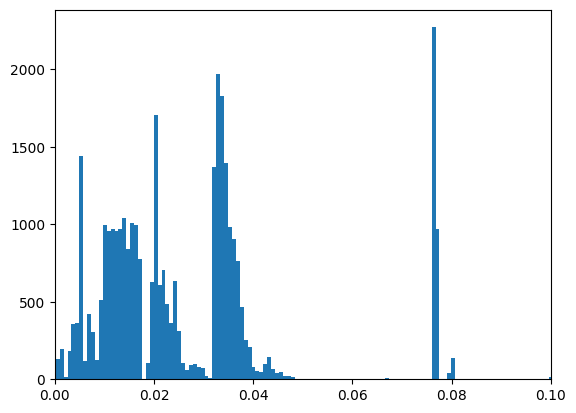

In [524]:
# order size distribution
plt.hist(orders.volume, bins = 1000)
plt.xlim([0, 0.1])

(0.0, 25000.0)

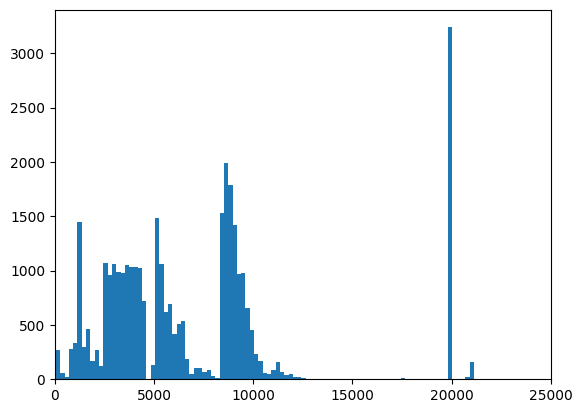

In [537]:
# dollar amount
ax = plt.hist(orders.volume * orders.price, bins = 1000)
plt.xlim([0, 25000])

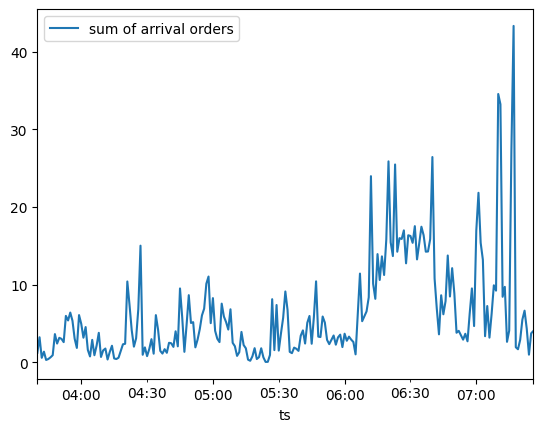

In [517]:
orders.set_index('ts').resample('1min').sum()['volume'].plot(label = "sum of arrival orders")
plt.legend()

<Axes: xlabel='ts'>

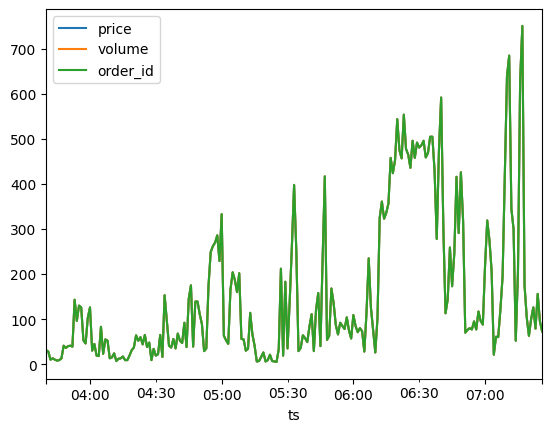

In [514]:
orders.set_index('ts').resample('1min').count().plot()

### How fast orders are cancelled after they are placed

In [544]:
orders = orders.rename(columns = {'ts':'arrival_ts'})

In [545]:
cancel = cancel.rename(columns = {'ts':'cancel_ts'})

In [549]:
quotes = orders.merge(cancel, how = 'left', on='order_id').dropna()

In [556]:
quotes['waiting_time']= (quotes['cancel_ts'] - quotes['arrival_ts']).dt.total_seconds()

In [561]:
quotes['waiting_time'].describe()

count    35157.000000
mean         9.845812
std        109.947336
min          0.009000
25%          0.376000
50%          0.478000
75%          0.752000
max       7037.583000
Name: waiting_time, dtype: float64